In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb

# Загрузим данные
 * При первом запуске скачаем train.csv и evaluation.csv
 * При повторных запусках файлы уже будут на месте

In [4]:
data = pd.DataFrame.from_csv("./train.csv")

In [ ]:
# data = data.loc[data['cancel_time']<5000]
X = data[data.columns[:len(data.columns)-1]]

In [5]:
y = data['burned']

In [ ]:
test = pd.DataFrame.from_csv("./test.csv")

In [ ]:
# len(X[X['cancel_time']<0])*1./len(X)
# X = X.loc[X['cancel_time']<500]
# plt.figure(figsize=(16, 8))
# X_notminusone = X.loc[X['cancel_time']!=-1]
# trsh = plt.hist(np.log(np.array([1.]*len(X_notminusone)) + X_notminusone['cancel_time'].values), bins=2000)
# plt.xlim(0., 7.)
# plt.ylim(0., 3000.)

In [ ]:
# plt.figure(figsize=(16, 8))
# trash = plt.hist( data.loc[(data['burned']==1) & (data['cancel_time']<100000)]['cancel_time'], bins=1000 )
# plt.ylim(0, 5000)
# plt.xlim(0, 100000)

In [ ]:
# data.loc[(data['burned']==0)]['cancel_time'].value_counts()

In [ ]:
# data.loc[(data['burned']==1)]['cancel_time'].value_counts()

In [ ]:
# test.head(1)

# citycenters

In [ ]:
#!!!!!
# X = pd.DataFrame.from_csv("./train_with_cityid.csv")

In [ ]:
centers = [
    [55.754216, 37.61343],  #0
    [51.661535, 39.200287], #1
    [56.326887, 44.005986], #2
    [55.798551, 49.106324], #3
    [59.939095, 30.315868]  #4
]

from geopy.distance import vincenty

minminmin = 10**15

def city_id(coords):
    mn = 0
    min_value = minminmin
    for i in range(len(centers)):
        
        dist = vincenty(coords, centers[i]).km
        if (dist < min_value):
            min_value = dist
            mn = i
    if (min_value > 10**3):
        return -1
    return mn

In [ ]:
XV = X.values
X['city_id'] = [city_id([x[5], x[6]]) for x in XV]

In [ ]:
X.to_csv('train_with_cityid.csv')

In [ ]:
# X = pd.read_csv('train_with_cityid.csv')

In [ ]:
testV = test.values
test['city_id'] = [city_id([x[3], x[4]]) for x in testV]

In [ ]:
test.to_csv('test_with_cityid.csv')

In [ ]:
# test = pd.read_csv('test_with_cityid.csv')

# concat

In [ ]:
print len(X.loc[X['driver_found']==True])
print len(y[y==False])


In [ ]:
x_col = ['dist', 'due', 'lat', 'lon', 'f_class', 's_class', 't_class', 'city_id']
X_and_test = pd.concat([X[x_col], test[x_col]])

# Preprocessing

In [ ]:
#Используем данные о праздниках отсюда - http://eduscan.net/help/calendar2014 http://newslab.ru/article/559455

holidays = "1.01,2.01,3.01,4.01,5.01,6.01,7.01,8.01,"\
"23.02,8.03,9.03,10.03,1.05,2.05,3.05,4.05,9.05,10.05,11.05,12.06,13.06".split(',')

holidays = map(lambda s: tuple(map(int,s.split('.'))),holidays)

#вытаскиватель категориальных фичей
from sklearn.feature_extraction import DictVectorizer
vectorizer = DictVectorizer(sparse=False,dtype=np.bool)

# используем встроенный питоновый парсер времени
from dateutil import parser

def preprocess_data(X_raw):

    #распарсим время
    datetimes = list(X_raw.due.apply(lambda x: parser.parse(x)))

    #время дня от 0 до 1
    rel_times = map(lambda dt: (dt.hour*60 + dt.minute)/(24.*60), datetimes)

    #день недели
    week_days = map( lambda x: x.isoweekday() , datetimes)

    rel_times = np.array(rel_times)
    week_days = np.array(week_days)
    
    is_holiday = map(lambda dt: (dt.day,dt.month) in holidays,
                 datetimes)

    dow_names = ['mon','tue','wed','thu','fri','sat','sun']
    
    
    data_dict = ( {'city_id':str(city_id), 
                   'f_class':f,
                   's_class':(s if (pd.isnull(s)) else (str(f) + str(s))),
                   't_class':(t if (pd.isnull(t)) else(str(f) + str(s) + str(t))),
                   'day_of_week':dow_names[day_of_week-1]}
                 
            for (city_id,f,s,t),day_of_week in zip(X_raw[['city_id', 
                                                         'f_class',
                                                         's_class',
                                                         't_class']].values, week_days) )

    
    Xcat = vectorizer.fit_transform(data_dict)

    other_features = ["dist","lat","lon"]
    
    Xreal = X_raw[other_features].values
    
    
    Xfull = np.concatenate([
            Xreal,
            Xcat            
        ],axis=1)
    
    Xfull = pd.DataFrame(Xfull,columns=other_features+vectorizer.feature_names_)
    
    Xfull["time_of_day_rel"] = rel_times
    Xfull["is_holiday"] = is_holiday

    
    return Xfull

In [ ]:
X_and_test = preprocess_data(X_and_test)

In [ ]:
X_and_test.to_csv('trainplustest_preprocessed.csv')

[ если всё упало ]

In [6]:
X_and_test = pd.read_csv('trainplustest_preprocessed.csv')

In [7]:
# y = data['burned'].values
X = X_and_test.head(len(y))
test = X_and_test[len(y):]

In [8]:
print X.shape, y.shape, test.shape
print data.shape

(1793300, 37) (1793300,) (743463, 37)
(1793300, 10)


# предскажем cancel_time

In [10]:
cancel_times = data['cancel_time']

In [11]:
print X.shape, cancel_times.shape

(1793300, 37) (1793300,)


In [19]:
cancel_times = np.log(cancel_times + np.array([2.]*len(cancel_times)))

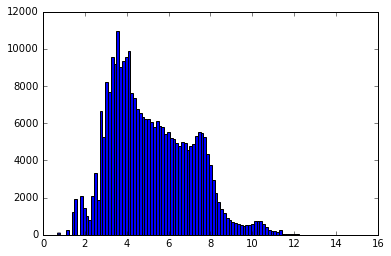

In [26]:
trash = plt.hist(cancel_times[cancel_times != 0], bins=100)

In [29]:
params = {} 
params['objective']           = "reg:linear"
# params['booster']             = "gbtree"
# params['eval_metric']         = "auc"
params['eta']                 = 0.1
# params['max_depth']           = 7
# params['subsample']           = 0.681
# params['colsample_bytree']    = 0.95
params['seed']                = 1337
params['njobs']               = -1
# params['silent']              = 1
bound = int(X.shape[0]*0.9)
x_train, x_val = X[:bound], X[bound:]
y_train, y_val = cancel_times[:bound], cancel_times[bound:]
 
dtrain = xgb.DMatrix(x_train, y_train)
dval = xgb.DMatrix(x_val, y_val)
# dtest = xgb.DMatrix(test)
watchlist = [(dval,'eval')]

In [30]:
num_trees = 300
esr = 10
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, verbose_eval=True, early_stopping_rounds = esr)

Will train until eval error hasn't decreased in 10 rounds.
[0]	eval-rmse:2.047193
[1]	eval-rmse:2.038254
[2]	eval-rmse:2.030922
[3]	eval-rmse:2.025003
[4]	eval-rmse:2.020052
[5]	eval-rmse:2.015950
[6]	eval-rmse:2.012551
[7]	eval-rmse:2.010087
[8]	eval-rmse:2.007712
[9]	eval-rmse:2.005691
[10]	eval-rmse:2.003893
[11]	eval-rmse:2.002563
[12]	eval-rmse:2.001363
[13]	eval-rmse:2.000261
[14]	eval-rmse:1.999548
[15]	eval-rmse:1.998738
[16]	eval-rmse:1.998023
[17]	eval-rmse:1.997519
[18]	eval-rmse:1.996954
[19]	eval-rmse:1.996536
[20]	eval-rmse:1.996009
[21]	eval-rmse:1.995701
[22]	eval-rmse:1.995471
[23]	eval-rmse:1.995283
[24]	eval-rmse:1.994960
[25]	eval-rmse:1.995025
[26]	eval-rmse:1.995127
[27]	eval-rmse:1.996980
[28]	eval-rmse:1.996794
[29]	eval-rmse:1.996943
[30]	eval-rmse:1.996970
[31]	eval-rmse:1.996848
[32]	eval-rmse:1.997264
[33]	eval-rmse:1.997248
[34]	eval-rmse:1.997394
Stopping. Best iteration:
[24]	eval-rmse:1.994960



In [31]:
gbm.best_ntree_limit

25

In [32]:
dtrain = xgb.DMatrix(X, cancel_times)
dtest = xgb.DMatrix(test)

In [33]:
gbm = xgb.train(params, dtrain, 25)

In [34]:
pred_cancel_time = gbm.predict(dtest, ntree_limit=25)

### ! Теперь у нас есть pred_cancel_time для test!!!!!

# cross validation

# learning

In [ ]:
import xgboost as xgb

In [ ]:
params = {} 
params['objective']           = "binary:logistic" 
params['booster']             = "gbtree"
params['eval_metric']         = "auc"
params['eta']                 = 0.006
params['max_depth']           = 7
params['subsample']           = 0.681
params['colsample_bytree']    = 0.95
params['seed']                = 1337
params['njobs']               = -1
params['silent']              = 1

In [ ]:
bound = int(X.shape[0]*0.9)
x_train, x_val = X[:bound], X[bound:]
y_train, y_val = y[:bound], y[bound:]
 
dtrain = xgb.DMatrix(x_train, y_train)
dval = xgb.DMatrix(x_val, y_val)
dtest = xgb.DMatrix(test)
watchlist = [(dval,'eval')]

In [ ]:
# bst = xgb.train(params=list(params.items()), dtrain=dtrain, num_boost_round=5000, early_stopping_rounds=12)
num_trees = 5000
esr = 12
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, verbose_eval=True, early_stopping_rounds = esr)
gbm.best_ntree_limit

In [ ]:
dtrain = xgb.DMatrix(X, y)
dtest = xgb.DMatrix(test)

In [ ]:
gbm = xgb.train(params, dtrain, 780)

In [ ]:
prediction = gbm.predict(dtest, ntree_limit=780)

# save

In [ ]:
response = pd.DataFrame()
response["Ids"] = np.arange(test.shape[0])
response["Y_prob"] = prediction
 
response.to_csv('kek779.csv',index=None)

In [ ]:
prediction = gbm.predict(dtrain, ntree_limit=780)

In [ ]:
response = pd.DataFrame()
response["Ids"] = np.arange(X.shape[0])
response["Y_prob"] = prediction
 
response.to_csv('train779.csv',index=None)

In [ ]:
# %%time
from sklearn.ensemble import RandomForestClassifier

#Также обучим более "случайную" версию RandomForest
model = RandomForestClassifier(n_estimators=779,n_jobs=16,min_samples_split=75,min_samples_leaf=20)

model.fit(X, y)

In [ ]:
res = model.predict_proba(test)

In [ ]:
# res = res[:, 1]

response = pd.DataFrame()
response["Ids"] = np.arange(test.shape[0])
response["Y_prob"] = res
 
response.to_csv('rf_test779.csv',index=None)

In [ ]:
res = model.predict_proba(X)

# res = res[:, 1]

response = pd.DataFrame()
response["Ids"] = np.arange(X.shape[0])
response["Y_prob"] = res
 
response.to_csv('rf_train779.csv',index=None)

In [ ]:
np.corr(res, prediction)

In [ ]:
# from datanight import plot_forest_feature_importances
# plot_forest_feature_importances(model,X.columns)

In [ ]:
# from datanight import generate_submission
# generate_submission(preprocess_data,model,"submission.csv")

# Советы по улучшению модели:

* Смотри глазами на данные - строй графики, исследуй аномалия 
 * это может принести новые идеи и отбросить нежизнеспособные намного раньше 
 * Туториал по библиотеке, в которой можно строить графики 
   * http://matplotlib.org/users/pyplot_tutorial.html
 * Ключевой вопрос самому себе - __"От чего ещё может зависеть, сгорит ли заказ?"__


* Попробуй более точно настроить модель или выбрать другую
 * Random Forest с текущими параметрами можно улучшить
   * Документация по нему - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
 * А можно использовать другие, более подходящие методы
   * Документация по методам - http://scikit-learn.org/stable/supervised_learning.html
 * Наконец, модели можно комбинировать
   * Например, усреднять с весами
   * В итоге качество может быть лучше, чем у каждой модели по отдельности
 * Важно не увлечься - зачастую качественные изменения решения намного лучше подкручивания параметров


* Подумай, какие ещё дополнительные данные можно провязать с выборкой? 
 * насколько реально применить их за отведённое время?


* __Главное__ - пытайся понять, дадут ли твои улучшения прирост на новых данных
 * Тестовая выборка находится по времени дальше, чем обучающая.
   * Например, нельзя использовать номер дня в году, потому что мы обучаемся на выборке __ДО__ начала контрольной
 * Это не значит, что нужно отправлять миллион решений на проверку и выбирать лучшее - это приведёт к переобучению
 